In [1]:
import gempy as gp
import rasterio
import geopandas as gpd
import numpy as np
import sys
sys.path.append('../../../gemgis')
import gemgis as gg
from matplotlib.colors import ListedColormap

import pandas as pd
import matplotlib.pyplot as plt
import os

from requests import Request
from owslib.wfs import WebFeatureService

import sys  
sys.path.append('src')
import read_GOCAD_ts

import pyvista as pv

from tqdm import tqdm


Some basic investigation via SARIG web services

In [3]:
#you need owlib for this to work
url = 'https://services.sarig.sa.gov.au/vector/geology/wfs?version=1.1.0'
wfs = gg.web.load_wfs(url)
wfs

In [4]:
print(wfs.identification.type, wfs.identification.title)
print([op.name for op in wfs.operations])
print(wfs.getOperationByName('GetFeature').formatOptions)
list(wfs.contents)

WFS GeoServer Web Feature Service
['GetCapabilities', 'DescribeFeatureType', 'GetFeature', 'Transaction', 'LockFeature', 'GetFeatureWithLock']
['{http://www.opengis.net/wfs}KML', '{http://www.opengis.net/wfs}GML2', '{http://www.opengis.net/wfs}GML3', '{http://www.opengis.net/wfs}SHAPE-ZIP', '{http://www.opengis.net/wfs}CSV', '{http://www.opengis.net/wfs}JSON']


['geology:100k_geology__visible_500k__mapunit',
 'geology:2m_geology__visible_5m',
 'geology:surface_geology_7m',
 'geology:apy_lands_palaeodrainage_neogene',
 'geology:all_petroleum_basins',
 'geology:archaean_to_early_mesoproterozoic',
 'geology:biostratigraphy__subset__mesozoic_cenozoic',
 'geology:cainozoic',
 'geology:cambrian_to_late_carboniferous',
 'geology:tertiary_coastal_barrier_sediments',
 'geology:field_observation_sites',
 'geology:induration_calareous',
 'geology:induration_ferruginous',
 'geology:induration_gypsiferous',
 'geology:induration_mixed_calcareous_and_gypsiferous',
 'geology:induration_siliceous',
 'geology:induration_undifferentiated',
 'geology:inverted_palaeochannel_sediments',
 'geology:jurassic_to_cretaceous',
 'geology:late_carboniferous_to_triassic',
 'geology:middle_to_late_mesoproterozoic',
 'geology:neoproterozoic',
 'geology:mesozoic_sediments',
 'geology:neogene_or_undifferentiated_tertiary_sediments',
 'geology:palaeogene_sediments',
 'geology:p

### Solid Geology Layers

We are interested in 'geology:middle_to_late_mesoproterozoic', 'geology:neoproterozoic', and 'geology:archaean_to_early_mesoproterozoic'
The middle mesoproterozoic can be downloaded individually from SARIG https://map.sarig.sa.gov.au/ but appears to be combined here as it is only small and a single unit in comparison

In [5]:
layers = ['geology:neoproterozoic','geology:middle_to_late_mesoproterozoic','geology:archaean_to_early_mesoproterozoic']

In [6]:
prot_list = []
for protlayer in layers:
    params = dict(service='WFS', version="1.1.0", request='GetFeature',typeName=protlayer, outputFormat='json')
    q = Request('GET', url, params=params).prepare().url

    prot_data = gpd.read_file(q)
    prot_list.append(prot_data)


Look at the Archaean layer

In [7]:
prot_list[2]

,id,OBJECTID,NAME,TIME_SLICE,SHAPE_LENG,SHAPE_LENGTH,SHAPE_AREA,geometry
0,archaean_to_early_mesoproterozoic.1,1,Kersaint Province,Archaean to early Mesoproterozoic,4.18,4.18,0.80,"POLYGON ((137.54431 -36.53662, 137.63713 -36.5..."
1,archaean_to_early_mesoproterozoic.2,2,Arunta Block,Archaean to early Mesoproterozoic,3.15,3.15,0.37,"POLYGON ((140.78366 -26.50348, 140.77137 -26.5..."
2,archaean_to_early_mesoproterozoic.3,3,Coompana Block,Archaean to early Mesoproterozoic,6.52,6.52,1.86,"POLYGON ((129.45560 -30.54582, 129.43437 -30.5..."
3,archaean_to_early_mesoproterozoic.4,4,Curnamona Province,Archaean to early Mesoproterozoic,9.25,9.25,4.05,"POLYGON ((139.57928 -29.76132, 139.59191 -29.7..."
4,archaean_to_early_mesoproterozoic.5,5,Gawler Province,Archaean to early Mesoproterozoic,37.64,37.64,66.93,"POLYGON ((138.00966 -27.04165, 138.01353 -27.1..."
5,archaean_to_early_mesoproterozoic.6,6,Gawler Province cratonic core (Gawler Craton),Archaean to early Mesoproterozoic,31.78,31.78,50.65,"MULTIPOLYGON (((136.25226 -27.40125, 136.30573..."


Plot the output to check

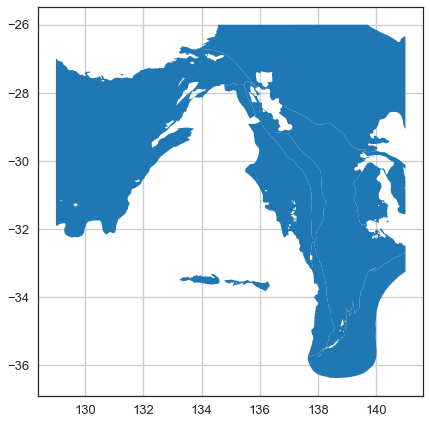

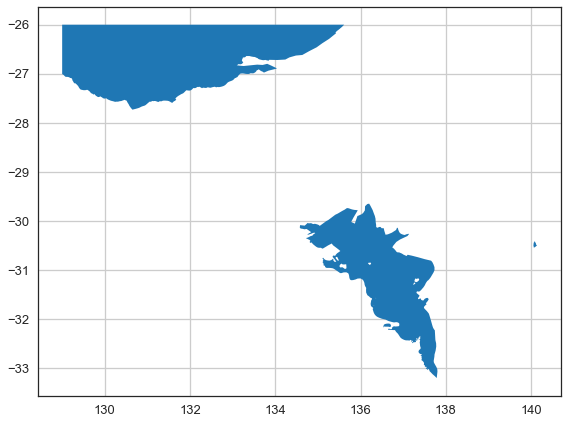

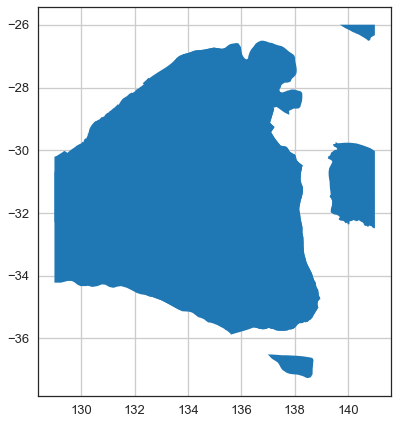

In [8]:
for protmap in prot_list:
    protmap.plot()
    plt.grid()

# SARIG Solid Geology GOCAD TS Surfaces

Thanks to SARIG we now have these available at https://sarigbasis.pir.sa.gov.au/WebtopEw/ws/samref/sarig1/cat0/Record?w=catno%3D2036881+OR+catno%3D2036883+OR+catno%3D2036887&sid=c2ca73f5685c43249e6c1ab5ec7dc2e5&set=1&m=3

An exercise left to the reader to download and unzip automatically, currently

Directories available

In [9]:
for root, dirs, files in os.walk('./GOCAD'):
    for d in dirs:
        print(d)

Archean-EarlyMesoprot
Faults
Late Mesoprot
Middle Mesoprot
Neoprot-Ordovician


So we have a Faults directory and the Middle Mesoprot layer has been split out, but perhaps we should combine them as per the polygons from the Web Services

In [10]:
#surfaces_list = [[] for i in range(5)]
surfaces = {}

for root, dirs, files in os.walk('./GOCAD'):
    #print(root)
    for index, d in enumerate(dirs):
        print(d)
        surfaces_list = []
        for rootd, dirsd, filesd in os.walk(os.path.join(root,d)) :
            for filed in filesd:
                print("- ", filed)
                surfaces_list.append(filed)    
        surfaces[d] = surfaces_list
                

Archean-EarlyMesoprot
-  0045_KersaintProvince.ts
-  0270_AruntaBlock_2.ts
-  0280_CoompanaBlock.ts
-  0410_BarossaComplex.ts
-  0435_MoolawatanaSuite.ts
-  0445_BenagerieVolc.ts
-  0455_MaficBimbowrie.ts
-  0460_MagBimbowrie.ts
-  0460_Nonmag_Bimbowrie.ts
-  0465_PoodlaHillSuite.ts
-  0470_LadyLouiseSuite.ts
-  0475_BassoSuite.ts
-  0485_UpperWillyama.ts
-  0490_BrokenHillGroup.ts
-  0495_LowerWillyama.ts
-  0500_Spilsby_Suite.ts
-  0510_Munjeela_Granite.ts
-  0520_Hiltaba_Suite.ts
-  0530_Gawler_Range_Volcanics.ts
-  0550_BlueRange_Corunna.ts
-  0555_NoolyeanaDomain2.ts
-  0560_FisherDomain.ts
-  0565_HughesDomain.ts
-  0570_St_Peter-Francis_Suite.ts
-  0580_Tunkillia_Suite.ts
-  0590_Engenina_Adamellite.ts
-  0590_Undiff_intrusives_KararanOrogeny.ts
-  0600_MoodySuite.ts
-  0605_Undiff_intrusives_Kimban_Orogeny.ts
-  0610_Tarcoola_Formation.ts
-  0635_Wallaroo_Group.ts
-  0640_PriceMetasediments.ts
-  0645_PeakeMetamorphics.ts
-  0655_MyolaVolcanics.ts
-  0665_CornyPointParagneiss.t

In [11]:
surfaces.keys()

dict_keys(['Archean-EarlyMesoprot', 'Faults', 'Late Mesoprot', 'Middle Mesoprot', 'Neoprot-Ordovician'])

## Plotting the Chronostratigraphic mesh groupings

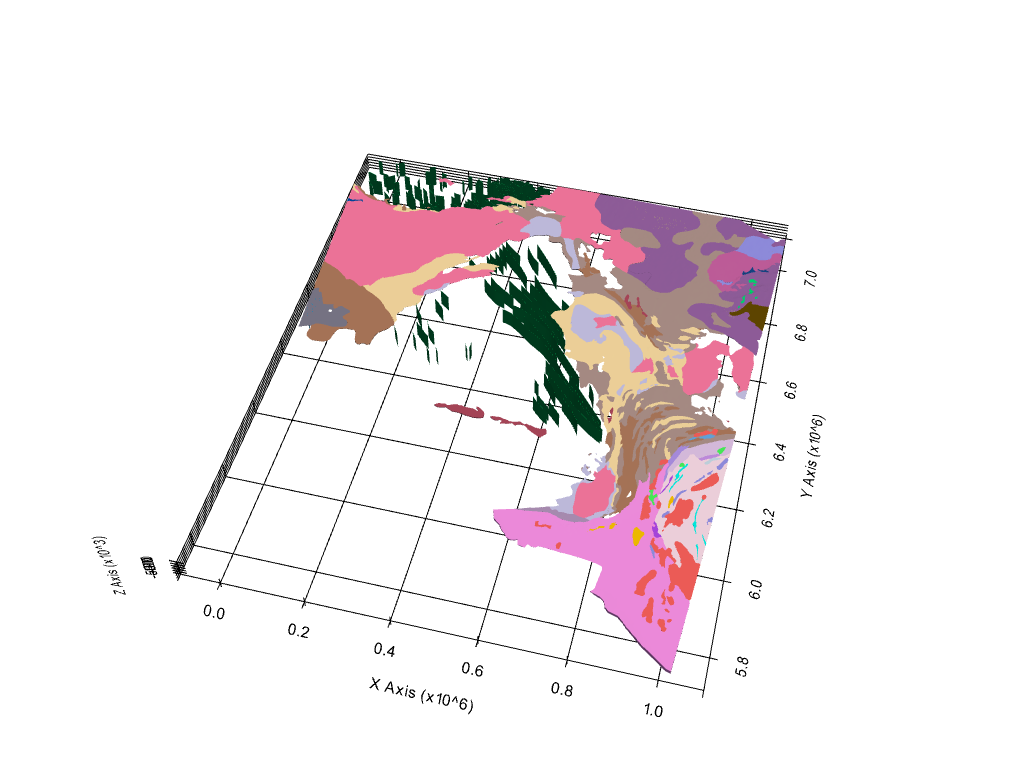

[(1051120.2998207707, 4223377.988216917, 2724224.742634127),
 (501379.234375, 6422342.25, -24480.584594726562),
 (0.0, 0.0, 1.0)]

In [12]:
surface_list = []
v_list = []
metadata_list = []
t_list = []
face_list = []

mesh_list = []

p = pv.Plotter(notebook=True)
#p = pv.Plotter(notebook=False)
              
chrono = 'Neoprot-Ordovician'
for index, d in enumerate(surfaces[chrono]):
    try:
        v, t = read_GOCAD_ts.read_GOCAD_ts_test('./GOCAD/' + chrono + '/' + str(d) )
        metadata = read_GOCAD_ts.check_GOCAD_ts('./GOCAD/' + chrono + '/'  + str(d) )
    except Except as gocadE:
        print(gocadE)
    except Except as gocadE:
        print(gocadE)

    t = t -1

    tri_index = t

    faces = np.empty_like(tri_index, shape=(tri_index.shape[0], 4) )
    faces[:, 0] = 3
    faces[:, 1:] = tri_index

    surf2 = pv.PolyData(v, faces)

    p.add_mesh(surf2.copy(), name=str(d), color=metadata["COLOR"][0:3])

    mesh_list.append(surf2)
    v_list.append(v)
    face_list.append(faces)
    metadata_list.append(metadata)
    surface_list.append(d)


dataset_list =[]    
for i, s in enumerate(surface_list):
    dataset = pd.DataFrame({'Group':'Neoprot-Ordovician','Surface': s, 'X': v_list[i][:, 0], 'Y': v_list[i][:, 1], 'Z': v_list[i][:, 2], 'SG': -1   })
    dataset["Name"] = metadata_list[i]["NAME"]
    dataset["CRS"] = str(metadata_list[i]["CRS"])
    dataset["Color"] = str(metadata_list[i]["COLOR"])

    dataset_list.append(dataset)

dfNeoprot_Ordovician = pd.concat(dataset_list)    

p.show_grid(color='black')
p.set_background(color='white')
p.show(cpos=(1,-4,5))
    

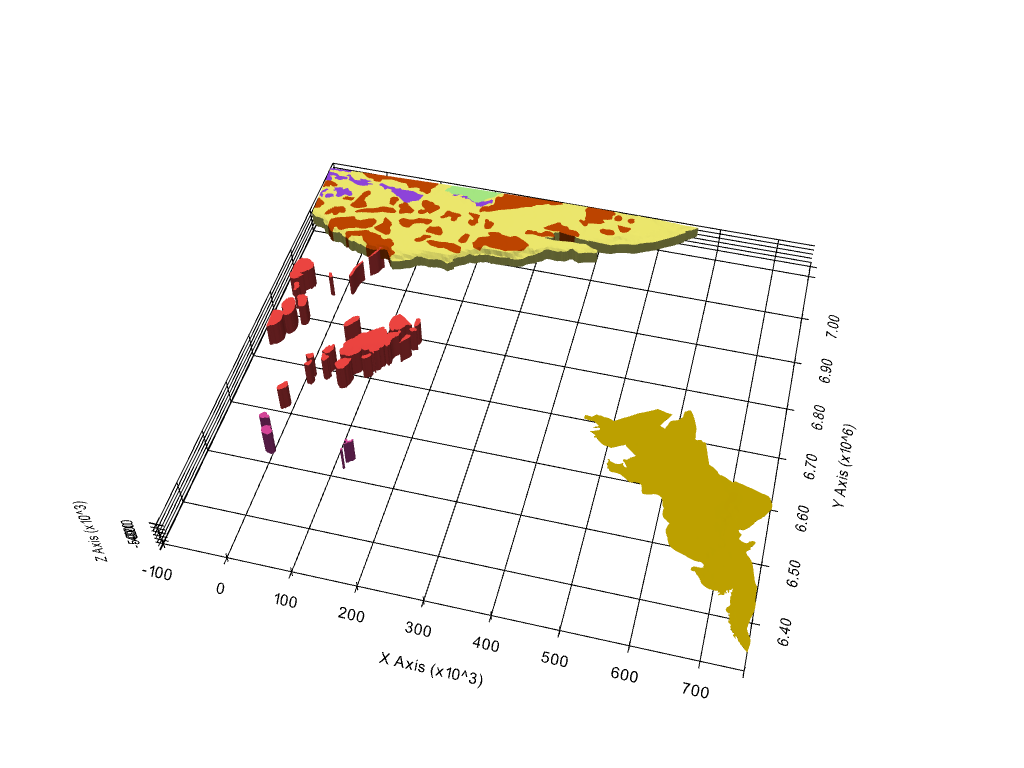

[(681774.0693693297, 5317941.597522682, 1732587.4808798516),
 (330366.46875, 6723572.0, -24450.522216796875),
 (0.0, 0.0, 1.0)]

In [13]:
p = pv.Plotter(notebook=True)
#p = pv.Plotter(notebook=False)
#'Late Mesoprot', 'Middle Mesoprot'
chrono = 'Late Mesoprot'
for index, d in enumerate(surfaces[chrono]):
    try:
        v, t = read_GOCAD_ts.read_GOCAD_ts_test('./GOCAD/' + chrono + '/' + str(d) )
        metadata = read_GOCAD_ts.check_GOCAD_ts('./GOCAD/' + chrono + '/'  + str(d) )
    except Except as gocadE:
        print(gocadE)

    t = t -1

    tri_index = t

    faces = np.empty_like(tri_index, shape=(tri_index.shape[0], 4) )
    faces[:, 0] = 3
    faces[:, 1:] = tri_index

    surf2 = pv.PolyData(v, faces)

    p.add_mesh(surf2.copy(), name=str(d), color=metadata["COLOR"][0:3])

    mesh_list.append(surf2)
    v_list.append(v)
    face_list.append(faces)
    metadata_list.append(metadata)
    surface_list.append(d)

chrono = 'Middle Mesoprot'
for index, d in enumerate(surfaces[chrono]):
    try:
        v, t = read_GOCAD_ts.read_GOCAD_ts_test('./GOCAD/' + chrono + '/' + str(d) )
        metadata = read_GOCAD_ts.check_GOCAD_ts('./GOCAD/' + chrono + '/'  + str(d) )
    except Except as gocadE:
        print(gocadE)

    t = t -1

    tri_index = t

    faces = np.empty_like(tri_index, shape=(tri_index.shape[0], 4) )
    faces[:, 0] = 3
    faces[:, 1:] = tri_index

    surf2 = pv.PolyData(v, faces)

    p.add_mesh(surf2.copy(), name=str(d), color=metadata["COLOR"][0:3])

    mesh_list.append(surf2)
    v_list.append(v)
    face_list.append(faces)
    metadata_list.append(metadata)
    surface_list.append(d)
    

dataset_list =[]    
for i, s in enumerate(surface_list):
    dataset = pd.DataFrame({'Group':'Late Middle Mesoprot','Surface': s, 'X': v_list[i][:, 0], 'Y': v_list[i][:, 1], 'Z': v_list[i][:, 2], 'SG': -1   })
    dataset["Name"] = metadata_list[i]["NAME"]
    dataset["CRS"] = str(metadata_list[i]["CRS"])
    dataset["Color"] = str(metadata_list[i]["COLOR"])

    dataset_list.append(dataset)

dfLate_Middle_Mesoprot = pd.concat(dataset_list)    

p.show_grid(color='black')
p.set_background(color='white')
p.show(cpos=(1,-4,5))
    

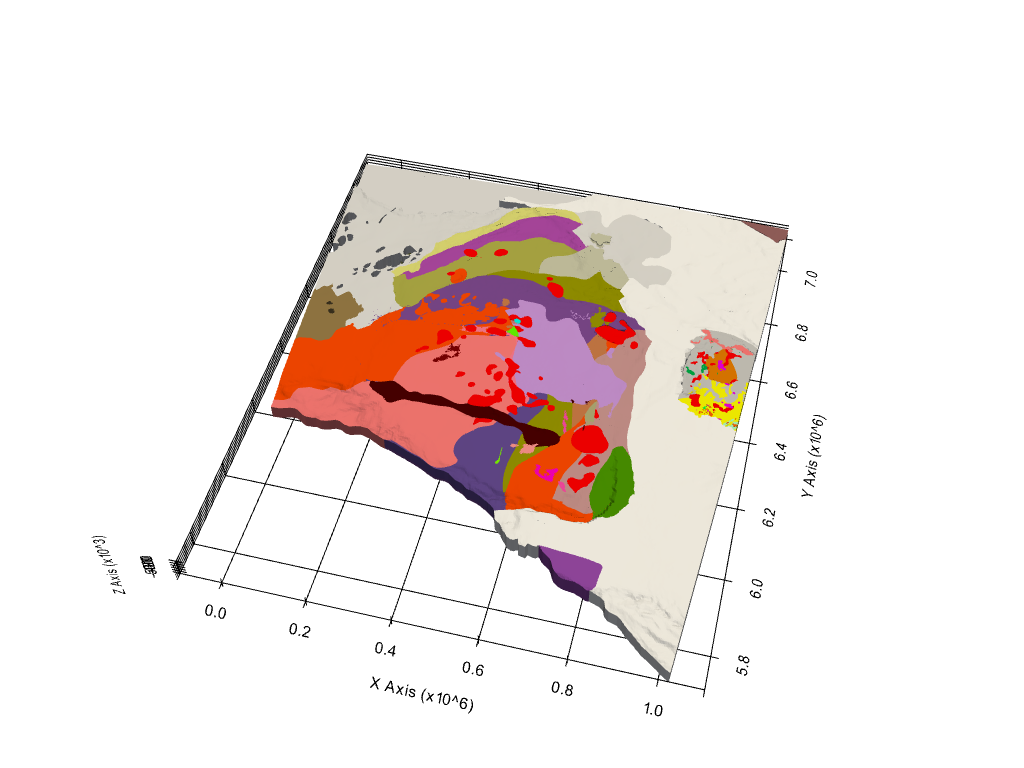

[(1051821.4289275582, 4214351.534289767, 2733887.593673435),
 (500094.125, 6421260.75, -24748.92596435547),
 (0.0, 0.0, 1.0)]

In [14]:
chrono = 'Archean-EarlyMesoprot'

p = pv.Plotter(notebook=True)
#p = pv.Plotter(notebook=False)
for index, d in enumerate(surfaces[chrono]):
    try:
        v, t = read_GOCAD_ts.read_GOCAD_ts_test('./GOCAD/' + chrono + '/' + str(d) )
        metadata = read_GOCAD_ts.check_GOCAD_ts('./GOCAD/' + chrono + '/'  + str(d) )
    except Except as gocadE:
        print(gocadE)

    t = t -1

    tri_index = t

    faces = np.empty_like(tri_index, shape=(tri_index.shape[0], 4) )
    faces[:, 0] = 3
    faces[:, 1:] = tri_index

    surf2 = pv.PolyData(v, faces)

    p.add_mesh(surf2.copy(), name=str(d), color=metadata["COLOR"][0:3])

    mesh_list.append(surf2)
    v_list.append(v)
    face_list.append(faces)
    metadata_list.append(metadata)
    surface_list.append(d)
    
dataset_list =[]    
for i, s in enumerate(surface_list):
    dataset = pd.DataFrame({'Group':'Archean-Early-Mesoprot','Surface': s, 'X': v_list[i][:, 0], 'Y': v_list[i][:, 1], 'Z': v_list[i][:, 2], 'SG': -1   })
    dataset["Name"] = metadata_list[i]["NAME"]
    dataset["CRS"] = str(metadata_list[i]["CRS"])
    dataset["Color"] = str(metadata_list[i]["COLOR"])
    
    dataset_list.append(dataset)
    
dfArchean_EarlyMesoprot = pd.concat(dataset_list)    
   

p.show_grid(color='black')
p.set_background(color='white')
p.show(cpos=(1,-4,5))
    

In [15]:
dfSolidGeology = pd.concat([dfNeoprot_Ordovician, dfLate_Middle_Mesoprot, dfArchean_EarlyMesoprot])
dfSolidGeology.head()            

,Group,Surface,X,Y,Z,SG,Name,CRS,Color
0,Neoprot-Ordovician,0025_O-i_InnaminckaFormation_2.ts,1022607.56,6938326.00,-3299.10,-1,0025_O-i_InnaminckaFormation,"{'NAME': 'from_Shape', 'AXIS_NAME': ['AXIS_NAM...","[0.090196, 0.294118, 0.596078]"
1,Neoprot-Ordovician,0025_O-i_InnaminckaFormation_2.ts,1022655.75,6938440.38,-3443.84,-1,0025_O-i_InnaminckaFormation,"{'NAME': 'from_Shape', 'AXIS_NAME': ['AXIS_NAM...","[0.090196, 0.294118, 0.596078]"
2,Neoprot-Ordovician,0025_O-i_InnaminckaFormation_2.ts,1022607.56,6938326.00,-3443.11,-1,0025_O-i_InnaminckaFormation,"{'NAME': 'from_Shape', 'AXIS_NAME': ['AXIS_NAM...","[0.090196, 0.294118, 0.596078]"
3,Neoprot-Ordovician,0025_O-i_InnaminckaFormation_2.ts,1022607.56,6938326.00,-3587.12,-1,0025_O-i_InnaminckaFormation,"{'NAME': 'from_Shape', 'AXIS_NAME': ['AXIS_NAM...","[0.090196, 0.294118, 0.596078]"
4,Neoprot-Ordovician,0025_O-i_InnaminckaFormation_2.ts,1022377.69,6937815.62,-3436.02,-1,0025_O-i_InnaminckaFormation,"{'NAME': 'from_Shape', 'AXIS_NAME': ['AXIS_NAM...","[0.090196, 0.294118, 0.596078]"


In [16]:
polygons = gg.vector.create_polygons_from_faces(mesh=mesh_list[0], crs='EPSG:28353')

In [17]:
polygons = polygons[polygons.is_valid]
polygons_merged = gg.vector.unify_polygons(polygons=polygons)
polygons_merged

,geometry
0,"POLYGON Z ((1002381.938 6917626.500 -2967.624,..."
1,"POLYGON Z ((1045151.438 6939029.750 -2578.248,..."


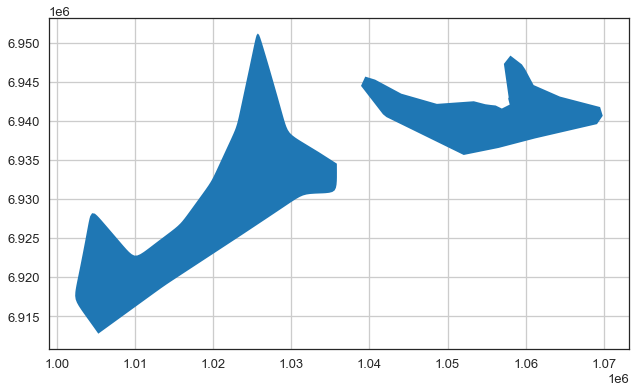

In [18]:
polygons_merged.plot()
plt.grid()

In [19]:
type(polygons_merged)

geopandas.geodataframe.GeoDataFrame

Compare the polygons above to the mesh they came from

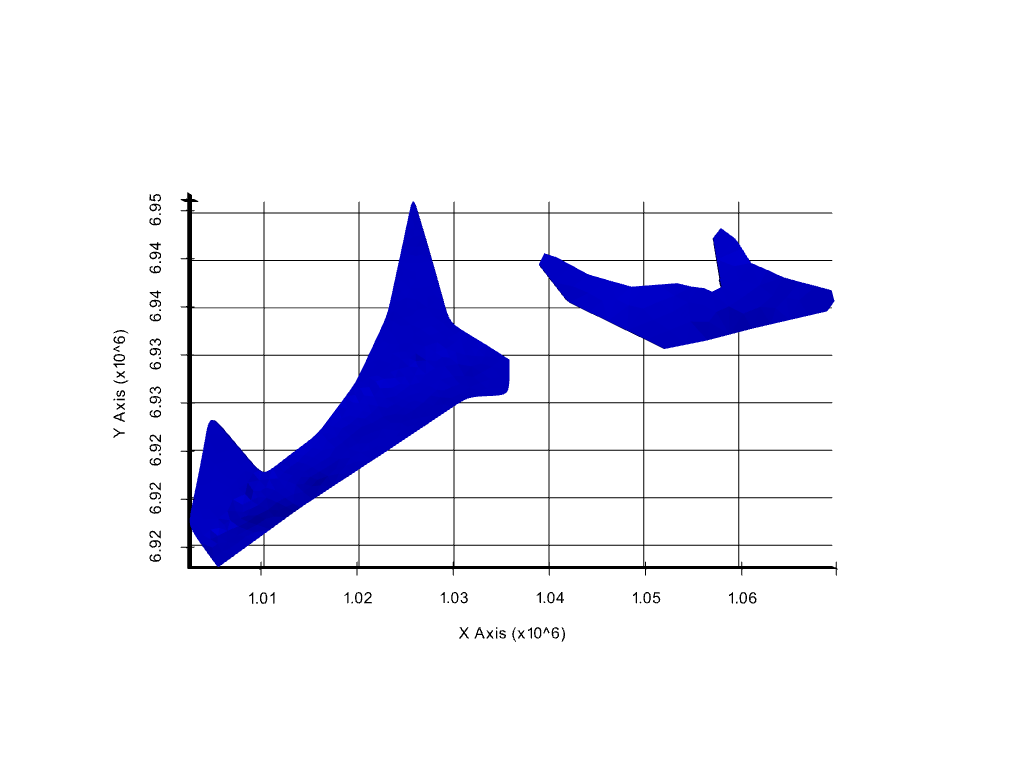

[(1036113.59375, 6931980.75, 147002.03055745314),
 (1036113.59375, 6931980.75, -2996.2260131835938),
 (0.0, 1.0, 0.0)]

In [20]:
p = pv.Plotter(notebook=True)
p.add_mesh(mesh_list[0], color="blue")
p.view_xy()
p.show_grid(color='black')
p.set_background(color='white')
p.show()
               

### Examine what we now have to work with alongside the list of meshes

In [21]:
metadata_list[0]

{'SURFACE': './GOCAD/Neoprot-Ordovician/0025_O-i_InnaminckaFormation_2.ts',
 'NAME': '0025_O-i_InnaminckaFormation',
 'COORD': 2,
 'TFACE': 2,
 'PVRTX': 0,
 'VRTX': 2436,
 'TRGL': 4864,
 'ATOM': 0,
 'CRS': {'NAME': 'from_Shape',
  'AXIS_NAME': ['AXIS_NAME', '"U"', '"V"', '"W"'],
  'AXIS_UNIT': ['AXIS_UNIT', '"m"', '"m"', '"m"'],
  'ZPOSITIVE': 'Elevation'},
 'COLOR': [0.090196, 0.294118, 0.596078]}

In [22]:
surface_list[0]

'0025_O-i_InnaminckaFormation_2.ts'

In [23]:
from typing import Union, List, Tuple, Optional, Sequence, Collection
import pyproj
from shapely.geometry.multipolygon import MultiPolygon
import shapely
from shapely import ops
from shapely import geometry
import pygeos
import fiona

#borrowed from GemGIS to work for this dataset

def unify_polygonsR(polygons: Union[List[shapely.geometry.polygon.Polygon], gpd.geodataframe.GeoDataFrame],
                   crs: Union[str, pyproj.crs.crs.CRS] = None,
                   return_gdf: bool = True,
                   ) -> Union[List[shapely.geometry.polygon.Polygon], gpd.geodataframe.GeoDataFrame]:

    # Checking that the polygons are of type list of a GeoDataFrame
    if not isinstance(polygons, (list, gpd.geodataframe.GeoDataFrame)):
        raise TypeError('Polygons must be provided as list of Shapely Polygons or as GeoDataFrame')

    # Checking GeoDataFrame
    if isinstance(polygons, gpd.geodataframe.GeoDataFrame):

        # Check that all entries of the gdf are of type Polygon
        if not all(polygons.geom_type == 'Polygon'):
            raise TypeError('All GeoDataFrame entries must be of geom_type Polygon')

        # Checking that all Shapely Objects are valid
        if not all(pygeos.is_valid(pygeos.from_shapely(polygons.geometry))):
            raise ValueError('Not all Shapely Objects are valid objects')

        # Checking that no empty Shapely Objects are present
        if any(pygeos.is_empty(pygeos.from_shapely(polygons.geometry))):
            raise ValueError('One or more Shapely objects are empty')

        # Storing CRS
        crs = polygons.crs

        # Creating list of geometries
        polygons = polygons['geometry'].tolist()

    # Checking that the crs is of type string or a pyproj object
    if not isinstance(crs, (str, type(None), pyproj.crs.crs.CRS)):
        raise TypeError('target_crs must be of type string or a pyproj object')

    # Checking that return gdfs is of type bool
    if not isinstance(return_gdf, bool):
        raise TypeError('Return_gdf argument must be of type bool')

    # Creating MultiPolygon from Polygons
    multi_polygons = geometry.MultiPolygon(polygons)
    
    #print(len(multi_polygons))
    #print("type of multi polygons:", type(multi_polygons))

    # Unifying polygons
    #print(multi_polygons[0:20])
    
    unified_polygons = ops.unary_union(geoms=multi_polygons)
    #unified_polygons = ops.unary_union(multi_polygons)
    
    #if type(unified_polygons) == 'shapely.geometry.polygon.Polygon'
        #unified_polygons = MultiPolygon([unified_polygons])

    
    #print(len(unified_polygons))
    #print("type of unified polygons:", type(unified_polygons))

    # Creating list of polygons
    try:
        polygons_merged = list(unified_polygons.geoms)
    except Exception as polyMultiE:
        unified_polygons = MultiPolygon([unified_polygons])
        polygons_merged = list(unified_polygons.geoms)

    # Creating GeoDataFrame
    if return_gdf:
        polygons_merged = gpd.GeoDataFrame(geometry=polygons_merged,
                                           crs=crs)

    return polygons_merged



In [24]:
polygons = gg.vector.create_polygons_from_faces(mesh=mesh_list[1], crs='EPSG:28353')
polygons = polygons[polygons.is_valid]
polygons_merged = unify_polygonsR(polygons=polygons)

In [25]:
polygons_list = []
for index, mesh in tqdm(enumerate(mesh_list), total=len(mesh_list) ):
    polygons = gg.vector.create_polygons_from_faces(mesh=mesh, crs='EPSG:28353')
    #print(surfaces_list[index], polygons.shape)
    polygons = polygons[polygons.is_valid]
    #print("valid:", polygons.shape)
    try:
        #polygons_merged = gg.vector.unify_polygons(polygons=polygons)
        polygons_merged = unify_polygonsR(polygons=polygons)
        polygons['CHRONO'] = metadata_list[index]['SURFACE'].split('/')[2]
        polygons['SURFACE'] = metadata_list[index]['SURFACE']
        polygons['NAME'] = metadata_list[index]['NAME']
        polygons['COLOR'] = str(metadata_list[index]['COLOR'])
        polygons_list.append(polygons)
    except Exception as polyE:
        print(surfaces_list[index], polyE)
    
df3Dpolygons = pd.concat(polygons_list)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [28:07<00:00, 15.07s/it]


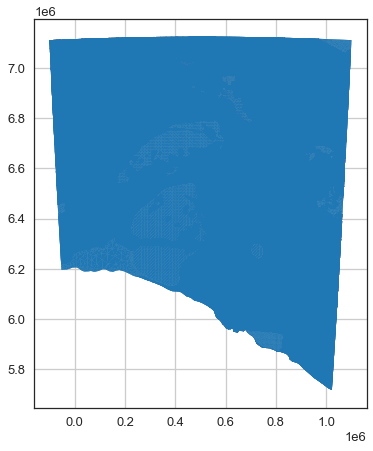

In [26]:
df3Dpolygons.plot()
plt.grid()

In [29]:
stratigraphy = ['Neoprot-Ordovician', 'Late Middle Mesoprot',  'Archean-EarlyMesoprot']

In [31]:
#need a formation column in the case above, this is CHRONO

gmap_sorted = gg.vector.sort_by_stratigraphy(gdf=df3Dpolygons, formation_column='CHRONO', stratigraphy=stratigraphy)

gmap_sorted

,geometry,CHRONO,SURFACE,NAME,COLOR
0,"POLYGON Z ((1011751.809 6918795.375 -2599.479,...",Neoprot-Ordovician,./GOCAD/Neoprot-Ordovician/0025_O-i_Innamincka...,0025_O-i_InnaminckaFormation,"[0.090196, 0.294118, 0.596078]"
1,"POLYGON Z ((863812.031 6628186.406 439.320, 86...",Neoprot-Ordovician,./GOCAD/Neoprot-Ordovician/0725_N_UndiffNeopro...,dtmz,"[0.694118, 0.596078, 0.596078]"
2,"POLYGON Z ((838278.609 7111823.750 -2542.149, ...",Neoprot-Ordovician,./GOCAD/Neoprot-Ordovician/0725_N_UndiffNeopro...,dtmz,"[0.694118, 0.596078, 0.596078]"
3,"POLYGON Z ((626669.594 6942782.438 -1845.662, ...",Neoprot-Ordovician,./GOCAD/Neoprot-Ordovician/0725_N_UndiffNeopro...,dtmz,"[0.694118, 0.596078, 0.596078]"
4,"POLYGON Z ((609895.375 6803993.156 -1494.042, ...",Neoprot-Ordovician,./GOCAD/Neoprot-Ordovician/0725_N_UndiffNeopro...,dtmz,"[0.694118, 0.596078, 0.596078]"
...,...,...,...,...,...
6098906,"POLYGON Z ((-22755.438 6200783.688 -19401.000,...",Archean-EarlyMesoprot,./GOCAD/Archean-EarlyMesoprot/0570_St_Peter-Fr...,0570_St_Peter-Francis_Suite,"[0.996078, 0.494118, 0.494118]"
6098907,"POLYGON Z ((409333.344 6122554.688 -26561.000,...",Archean-EarlyMesoprot,./GOCAD/Archean-EarlyMesoprot/0570_St_Peter-Fr...,0570_St_Peter-Francis_Suite,"[0.996078, 0.494118, 0.494118]"
6098908,"POLYGON Z ((511365.313 6362984.906 -51.000, 51...",Archean-EarlyMesoprot,./GOCAD/Archean-EarlyMesoprot/0570_St_Peter-Fr...,0570_St_Peter-Francis_Suite,"[0.996078, 0.494118, 0.494118]"
6098909,"POLYGON Z ((436000.000 6225039.063 -17041.000,...",Archean-EarlyMesoprot,./GOCAD/Archean-EarlyMesoprot/0570_St_Peter-Fr...,0570_St_Peter-Francis_Suite,"[0.996078, 0.494118, 0.494118]"


In [35]:
gmap_sorted['formation'] = gmap_sorted['CHRONO']

In [ ]:
intersection = gg.vector.extract_xy_from_polygon_intersections(gdf=gmap_sorted)

In [ ]:
intersection.plot(column='formation', aspect='equal', legend=True)
plt.grid()

In [ ]:
p = pv.Plotter(notebook=True)
p.add_mesh(mesh_list[1], color="blue")
p.view_xy()
p.show_grid(color='black')
p.set_background(color='white')
p.show()
               